# Online Joint State and Parameters Estimation for AR SSM 
State space model
\begin{align*}
    &\mathbf{x}_t = \mathbf{A}\mathbf{x}_{t-1} + \mathbf{p}_t \quad \mathbf{p}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{I}\gamma_x^{-1}) \\
    &y_t = \mathbf{c}^\text{T}\mathbf{x}_t + m_t \quad v_t \sim \mathcal{N}(0, \gamma_y^{-1})
\end{align*}

or

\begin{align*}
     &p(\mathbf{x}_t\,|\,\mathbf{x}_{t-1},\mathbf{a},\gamma) = \mathcal{N}\left(\mathbf{x}_t\;\middle|\; \mathbf{A}\mathbf{x}_{t-1},  \mathbf{I}\gamma_x^{-1} \right)\\
    &p(y_t\,|\,\mathbf{x}_{t}) = \mathcal{N}\left(y_t \;\middle|\;\mathbf{c}^\text{T}\mathbf{x}_t, \gamma_y^{-1} \right)
\end{align*}

where
\begin{align*}
    &\mathbf{x}_t = (x_t, x_{t-1}, \dots, x_{t-p+1})^\text{T} \quad \mathbf{x}_{t-1} = (x_{t-1}, x_{t-2}, \dots, x_{t-p})^\text{T} 
    \\ \\
    &\mathbf{A} = 
    \begin{bmatrix}
        a_1 & a_2 & a_3 & \dots & a_p \\
        1 & 0 & 0 & \dots & 0 \\ 
        0 & 1 & 0 & \dots & 0 \\   
        \vdots & \vdots & \vdots & \ddots & \vdots \\
        0 & 0 & 0 & \dots & 0
    \end{bmatrix}
    =
    \begin{bmatrix}
         \mathbf{a}^\text{T} \\
         \mathbf{I}_{p-1} \quad \mathbf{0}
    \end{bmatrix}
    \\ \\
    &\mathbf{I} = \mathbf{I}_p = 
    \begin{bmatrix}
        1 & 0 & 0 & \dots & 0 \\ 
        0 & 1 & 0 & \dots & 0 \\   
        \vdots & \vdots & \vdots & \ddots & \vdots \\
        0 & 0 & 0 & \dots & 1
    \end{bmatrix} \\
\end{align*}

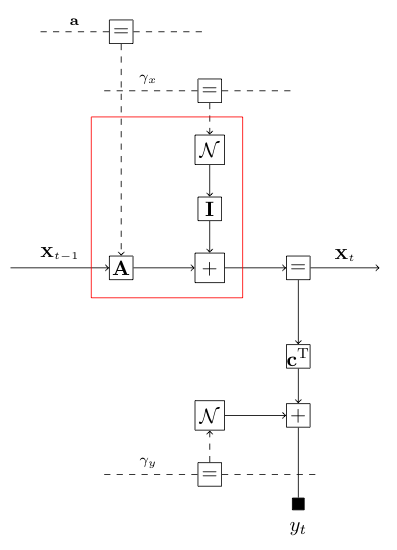

In [219]:
using Images
img = load("../ffgs/HAR-online.png")

The central quantity of our interest is a joint estimation of the AR coefficients $\mathbf{a}$, precision of process noise $\gamma_x$ and states $\mathbf{x}_n$, while setting measurement noise precisions $\gamma_y=\frac{1}{2}$.

In [1]:
using ProgressMeter
using Revise
using ForneyLab
include( "../AR-node/autoregression.jl")
include("../AR-node/rules_prototypes.jl")
include("../AR-node/vmp_rules.jl")
include( "../AR-node/observationAR.jl")
# helpers for evaluation of the model
include("../helpers/functions.jl")
# module to generate data for AR
include("../data/ARdata.jl")
import Main.ARdata: loadAR, generateAR, writeAR, readAR
import LinearAlgebra.I, LinearAlgebra.Symmetric
import ForneyLab: unsafeCov, unsafeMean, unsafePrecision
using Plots

In [31]:
# Define the order and data
ARorder = 2
diagAR(dim) = Matrix{Float64}(I, dim, dim)

# AR data
a = 1.0; b = 1.0
γ_x = a/b # process noise precision
coefs, data = generateAR(100, ARorder, 1.0, noise_variance=γ_x^-1)
#x = loadAR("../data/temperature.csv", ARorder, col=:Temp)
#coefs, data = generate_sin(1000, tiny)
# writeAR(coefs, x, folder="../data")
#coefs, x = readAR("../data/AR(2).csv")

# Remove ARorder samples from x
x = [x[1] for x in data[ARorder + 1:end]]

γ_y = 1/2 # measurement noise precision
# Observations
y = [x + sqrt(γ_y)^-1*randn() for x in x];

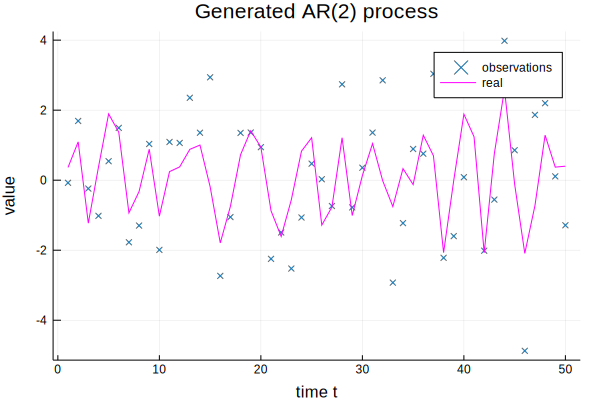

In [32]:
# Plotting the data
from = 1; to = 50;
scatter(y[from:to], markershape = :xcross, markeralpha = 0.6,
        markersize = 2, xlabel="time t", ylabel="value", label="observations")
plot!(x[from:to], color=:magenta, label="real", title="Generated AR($ARorder) process")

In [41]:
# Building the model
g = FactorGraph()

# declare priors as random variables
@RV m_x_t_prev
@RV w_x_t_prev
@RV m_a
@RV w_a
@RV m_y_t
@RV w_y_t
@RV a_w
@RV b_w

@RV a ~ GaussianMeanPrecision(m_a, w_a)
@RV x_t_prev ~ GaussianMeanPrecision(m_x_t_prev, w_x_t_prev)
@RV w ~ Gamma(a_w, b_w)
@RV x_t = AR(a, x_t_prev, w)
observationAR(m_y_t, x_t, w_y_t)

# Placeholders for prior
placeholder(m_a, :m_a, dims=(ARorder,))
placeholder(w_a, :w_a, dims=(ARorder, ARorder))

# Placeholder for data
placeholder(m_x_t_prev, :m_x_t_prev, dims=(ARorder,))
placeholder(w_x_t_prev, :w_x_t_prev, dims=(ARorder, ARorder))
placeholder(a_w, :a_w)
placeholder(b_w, :b_w)
placeholder(m_y_t, :m_y_t)
placeholder(w_y_t, :w_y_t)

ForneyLab.draw(g)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 17653559826115003826 -->
 
 17653559826115003826 
 
 placeholder_w_y_t 
 
<!-- 7669475624197384274 -->
 
 7669475624197384274 
 
 observationAR 
 observationar_1 
 
<!-- 17653559826115003826--7669475624197384274 -->
 
 17653559826115003826--7669475624197384274 
 
 w_y_t 
 3 z 
 1 out 
 
<!-- 4608911878358311313 -->
 
 4608911878358311313 
 
 placeholder_b_w 
 
<!-- 17970452361690956000 -->
 
 17970452361690956000 
 
 Gam 
 gamma_1 
 
<!-- 4608911878358311313--17970452361690956000 -->
 
 4608911878358311313--17970452361690956000 
 
 b_w 
 3 b 
 1 out 
 
<!-- 16178297271454911334 -->
 
 16178297271454911334 
 
 placeholder_w_x_t_prev 
 
<!-- 12780614640594999035 -->
 
 12780614640594999035 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 16178297271454911334--12780614640594999035 -->
 
 16178297271454911334--12780614640594999035 
 
 w_x_t_prev 
 3 w 
 1 out 
 
<!-- 15599246522610413849 -->
 
 15599246522610413849 
 
 placeholder_m_a 
 
<!-- 10807761851523270794 -->
 
 10807761851523270794 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 15599246522610413849--10807761851523270794 -->
 
 15599246522610413849--10807761851523270794 
 
 m_a 
 2 m 
 1 out 
 
<!-- 1003310529138757520 -->
 
 1003310529138757520 
 
 Autoregression 
 autoregression_1 
 
<!-- 7669475624197384274--1003310529138757520 -->
 
 7669475624197384274--1003310529138757520 
 
 x_t 
 1 out 
 2 x 
 
<!-- 1003310529138757520--17970452361690956000 -->
 
 1003310529138757520--17970452361690956000 
 
 w 
 1 out 
 4 W 
 
<!-- 1003310529138757520--10807761851523270794 -->
 
 1003310529138757520--10807761851523270794 
 
 a 
 1 out 
 3 a 
 
<!-- 1003310529138757520--12780614640594999035 -->
 
 1003310529138757520--12780614640594999035 
 
 x_t_prev 
 1 out 
 2 x 
 
<!-- 13475132321102751696 -->
 
 13475132321102751696 
 
 placeholder_a_w 
 
<!-- 13475132321102751696--17970452361690956000 -->
 
 13475132321102751696--17970452361690956000 
 
 a_w 
 2 a 
 1 out 
 
<!-- 9213088492212341005 -->
 
 9213088492212341005 
 
 placeholder_w_a 
 
<!-- 9213088492212341005--10807761851523270794 -->
 
 9213088492212341005--10807761851523270794 
 
 w_a 
 3 w 
 1 out 
 
<!-- 11305313646007123051 -->
 
 11305313646007123051 
 
 placeholder_m_x_t_prev 
 
<!-- 11305313646007123051--12780614640594999035 -->
 
 11305313646007123051--12780614640594999035 
 
 m_x_t_prev 
 2 m 
 1 out 
 
<!-- 11686805972991594439 -->
 
 11686805972991594439 
 
 placeholder_m_y_t 
 
<!-- 11686805972991594439--7669475624197384274 -->
 
 11686805972991594439--7669475624197384274 
 
 m_y_t 
 1 y 
 1 out

In [42]:
# Specify recognition factorization
q = RecognitionFactorization(a, x_t, x_t_prev, w, ids=[:A :X_t :X_t_prev :W])

# Generate the variational update algorithms for each recognition factor
algo = variationalAlgorithm(q)
algoF = freeEnergyAlgorithm(q)

# Load algorithms
eval(Meta.parse(algo))
eval(Meta.parse(algoF))

freeEnergy (generic function with 1 method)

In [43]:
# Define values for prior statistics
a_w_0 = 0.0001
b_w_0 = 0.0001
m_a_0 = zeros(ARorder)
w_a_0 = diagAR(ARorder)
m_x_prev_0 = zeros(ARorder)
w_x_prev_0 = 0.1*diagAR(ARorder)

m_x = Vector{Vector{Float64}}(undef, length(y))
w_x = Vector{Array{Float64, 2}}(undef, length(y))
m_a = Vector{Vector{Float64}}(undef, length(y))
w_a = Vector{Array{Float64, 2}}(undef, length(y))
a_w = Vector{Float64}(undef, length(y))
b_w = Vector{Float64}(undef, length(y))

m_x_t_prev_min = m_x_prev_0
w_x_t_prev_min = w_x_prev_0
m_a_min = m_a_0
w_a_min = w_a_0
a_w_min = a_w_0
b_w_min = b_w_0;

In [44]:
data = Dict()
marginals = Dict()
n_its = 5

# Storage for scores
WMSEs = []
FAR = []

p = Progress(length(y), 1, "Observed ")
for t in 1:length(y)
    update!(p, t)
    marginals[:a] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_a_min, w=w_a_min)
    marginals[:x_t_prev] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_x_t_prev_min, w=w_x_t_prev_min)
    marginals[:w] = ProbabilityDistribution(Univariate, Gamma, a=a_w_min, b=b_w_min)
    global m_x_t_prev_min, w_x_t_prev_min, m_a_min, w_a_min, a_w_min, b_w_min, data

    for i = 1:n_its
        data = Dict(:m_y_t => y[t],
                    :w_y_t => γ_y,
                    :m_a => m_a_min,
                    :w_a => w_a_min,
                    :m_x_t_prev => m_x_t_prev_min,
                    :w_x_t_prev => w_x_t_prev_min,
                    :a_w => a_w_min,
                    :b_w => b_w_min)
        stepX_t!(data, marginals)
        stepA!(data, marginals)
        stepW!(data, marginals)
        #stepX_t_prev!(data, marginals)
        #stepX_t!(data, marginals)
        m_a[t] = unsafeMean(marginals[:a])
        w_a[t] = unsafePrecision(marginals[:a])
        m_x[t] = unsafeMean(marginals[:x_t])
        w_x[t] = unsafePrecision(marginals[:x_t])
        a_w[t] = marginals[:w].params[:a]
        b_w[t] = marginals[:w].params[:b]
        m_a_min = m_a[t]
        w_a_min = w_a[t]
        m_x_t_prev_min = m_x[t]
        w_x_t_prev_min = w_x[t]
        a_w_min = a_w[t]
        b_w_min = b_w[t]
    end
    push!(FAR, (freeEnergy(data, marginals))) 
    push!(WMSEs, wmse(x[1:t], [est[1] for est in m_x[1:t]]))
end

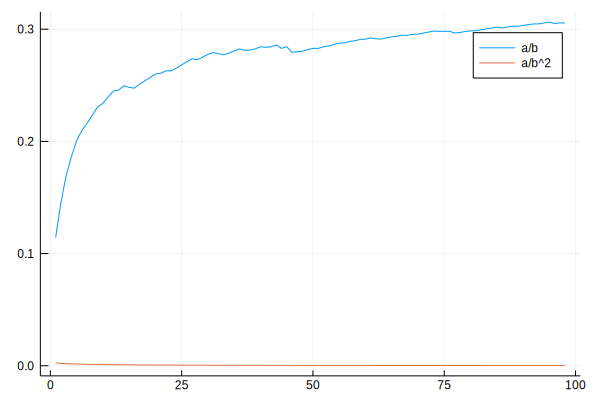

In [45]:
plot(a_w ./ b_w, label="a/b")
plot!(a_w ./ b_w .^2, label="a/b^2")

In [46]:
# Extracting estimates for x_t (first component of vector x̄_t) for plotting
m_ar = [m_x[1] for m_x in [m_x[1] for m_x in m_x[1:end]]]
v_ar = [v_x[1]^-1 for v_x in [v_x[1][1] for v_x in w_x[1:end]]];

In [47]:
# Estimations
println("Coefs\n=========")
println("Estimated ", mean(marginals[:a]))
println("True ", coefs)

println("\nProcess noise variance\n=========")
println("Estimated ", mean(marginals[:w])^-1)
println("True ", γ_x^-1)

println("\nState\n=========")
println("Mean ", mean(marginals[:x_t]))
println("Var ", unsafeCov(marginals[:x_t]))

Coefs
Estimated [-0.0053884, -0.024294]
True [0.0538306, -0.503472]

Process noise variance
Estimated 3.2729947055017563
True 1.0

State
Mean [1.3868, 0.809691]
Var [1.24123 -0.0; -0.0 3.27166]


In [48]:
# Doesn't really matter
println("Δ(estimated, real)=", mse(m_ar, x))
println("Δ(estimated, noise)=", mse(m_ar, y))
println("Δ(noise, actual)=", mse(y, x))

Δ(estimated, real)=0.8417382683081301
Δ(estimated, noise)=0.40668040278437684
Δ(noise, actual)=1.807462290799781


# Random walk model 
As a benchamrk, we use the following RW model.
\begin{align*}
    &x_t = x_{t-1} + p_t \quad p_t \sim \mathcal{N}(0, \gamma_x^{-1}) \\
    &y_t = x_t + m_t \quad m_t \sim \mathcal{N}(0, \gamma_y^{-1})
\end{align*}

We set $\gamma_y = \frac{1}{2}$

In [14]:
# Generate data first!

rwg = FactorGraph()

# declare priors as random variables
@RV a_w
@RV b_w
@RV m_x_t_prev
@RV w_x_t_prev
@RV w_y_t

@RV w ~ Gamma(a_w, b_w)
@RV x_t_prev ~ GaussianMeanPrecision(m_x_t_prev, w_x_t_prev)
@RV x_t ~ GaussianMeanPrecision(x_t_prev, w)
@RV y_t ~ GaussianMeanPrecision(x_t, w_y_t)

# Placeholders for prior
placeholder(a_w, :a_w)
placeholder(b_w, :b_w)
placeholder(m_x_t_prev, :m_x_t_prev)
placeholder(w_x_t_prev, :w_x_t_prev)

# Placeholder for data
placeholder(y_t, :y_t)
placeholder(w_y_t, :w_y_t)
ForneyLab.draw(rwg)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 12043974008337001178 -->
 
 12043974008337001178 
 
 placeholder_w_y_t 
 
<!-- 13801068180966635864 -->
 
 13801068180966635864 
 
 𝒩 
 gaussianmeanprecision_3 
 
<!-- 12043974008337001178--13801068180966635864 -->
 
 12043974008337001178--13801068180966635864 
 
 w_y_t 
 3 w 
 1 out 
 
<!-- 15191070884599124748 -->
 
 15191070884599124748 
 
 placeholder_a_w 
 
<!-- 6801738929521739104 -->
 
 6801738929521739104 
 
 Gam 
 gamma_1 
 
<!-- 15191070884599124748--6801738929521739104 -->
 
 15191070884599124748--6801738929521739104 
 
 a_w 
 2 a 
 1 out 
 
<!-- 859862250692441170 -->
 
 859862250692441170 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 13801068180966635864--859862250692441170 -->
 
 13801068180966635864--859862250692441170 
 
 x_t 
 1 out 
 2 m 
 
<!-- 17292494526906303914 -->
 
 17292494526906303914 
 
 placeholder_m_x_t_prev 
 
<!-- 2687722720512737749 -->
 
 2687722720512737749 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 17292494526906303914--2687722720512737749 -->
 
 17292494526906303914--2687722720512737749 
 
 m_x_t_prev 
 2 m 
 1 out 
 
<!-- 9078745473609143454 -->
 
 9078745473609143454 
 
 placeholder_b_w 
 
<!-- 9078745473609143454--6801738929521739104 -->
 
 9078745473609143454--6801738929521739104 
 
 b_w 
 3 b 
 1 out 
 
<!-- 11047444979911624412 -->
 
 11047444979911624412 
 
 placeholder_y_t 
 
<!-- 11047444979911624412--13801068180966635864 -->
 
 11047444979911624412--13801068180966635864 
 
 y_t 
 1 out 
 1 out 
 
<!-- 6752978150828541605 -->
 
 6752978150828541605 
 
 placeholder_w_x_t_prev 
 
<!-- 6752978150828541605--2687722720512737749 -->
 
 6752978150828541605--2687722720512737749 
 
 w_x_t_prev 
 3 w 
 1 out 
 
<!-- 859862250692441170--2687722720512737749 -->
 
 859862250692441170--2687722720512737749 
 
 x_t_prev 
 1 out 
 2 m 
 
<!-- 859862250692441170--6801738929521739104 -->
 
 859862250692441170--6801738929521739104 
 
 w 
 1 out 
 3 w

In [15]:
# Specify recognition factorization
q = RecognitionFactorization(x_t, w, ids=[:X_t :W])

# Generate the variational update algorithms for each recognition factor
algo = variationalAlgorithm(q)
algoF = freeEnergyAlgorithm()

eval(Meta.parse(algo))
eval(Meta.parse(algoF))

freeEnergy (generic function with 1 method)

In [19]:
# Define values for prior statistics
m_x_prev_0 = 0.0
w_x_prev_0 = 0.1
# FIXME
a_w_0 = 0.0001
b_w_0 = 0.0001

n_samples = length(y)
a_w = Vector{Float64}(undef, n_samples)
b_w = Vector{Float64}(undef, n_samples)
m_x = Vector{Float64}(undef, n_samples)
w_x = Vector{Float64}(undef, n_samples)

m_x_t_prev_min = m_x_prev_0
w_x_t_prev_min = w_x_prev_0
a_w_t_min = a_w_0
b_w_t_min = b_w_0;

In [20]:
data = Dict()
marginals = Dict()
n_its = 5

# Storage for score
WMSEsRW = []
FRW = []

p = Progress(length(y), 1, "Observed ")
for t = 1:length(y)
    update!(p, t)
    marginals[:x_t_prev] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=m_x_t_prev_min, w=w_x_t_prev_min)
    marginals[:w] = ProbabilityDistribution(Univariate, Gamma, a=a_w_t_min, b=b_w_t_min)
    global m_x_t_prev_min, w_x_t_prev_min, a_w_t_min, b_w_t_min, data
    
    for i = 1:n_its
        data = Dict(:y_t => y[t],
                    :w_y_t => γ_y,
                    :m_x_t_prev => m_x_t_prev_min,
                    :w_x_t_prev => w_x_t_prev_min,
                    :a_w => a_w_t_min,
                    :b_w => b_w_t_min)
        
        stepX_t!(data, marginals)
        stepW!(data, marginals)
        m_x[t] = mean(marginals[:x_t])
        w_x[t] = var(marginals[:x_t])^-1
        a_w[t] = marginals[:w].params[:a]
        b_w[t] = marginals[:w].params[:b]
        
        m_x_t_prev_min = m_x[t]
        w_x_t_prev_min = w_x[t]
        a_w_t_min = a_w[t]
        b_w_t_min = b_w[t]
    end
    push!(FRW, (freeEnergy(data, marginals)))
    push!(WMSEsRW, wmse(x[1:t], m_x[1:t]))
end

In [21]:
println("Process noise variance\n=========")
println("Estimated ", mean(marginals[:w])^-1)
println("True ", 1.0)

println("\nState\n=========")
println("Mean ", mean(marginals[:x_t]))
println("Var ", var(marginals[:x_t]))

Process noise variance
Estimated 2.5903470151264427
True 1.0

State
Mean 0.3518622044329248
Var 0.7215467080194935


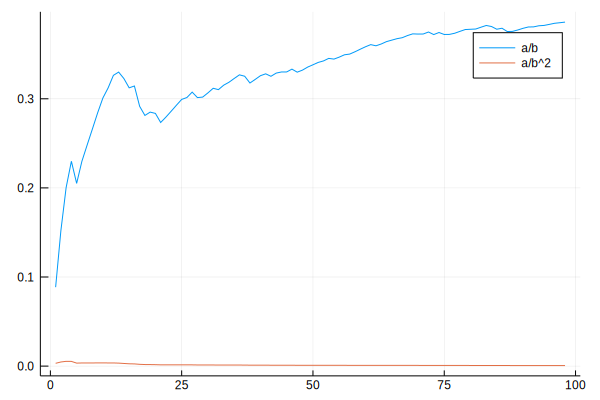

In [22]:
plot(a_w ./ b_w, label="a/b")
plot!(a_w ./ b_w .^2, label="a/b^2")

In [23]:
# Extracting estimates for x_t (first component of vector x̄_t) for plotting
m_rw = [m_x[1] for m_x in m_x[1:end]];
v_rw = [v_x[1]^-1 for v_x in w_x[1:end]];

# Comparison
To assess the performance of our model, we use the following metrics:
$$\sum_{i=1}^Te^{i-T}(m_{x_{k}}-x_{k})^2$$
where
$m_{x_{k}}$ - estimated mean of the hidden state,
$v_{x_{k}}$ - estimated variance of the hidden state,
$T$ - number of available observations

and Free Energy:
$$F_t[q]\triangleq \int q(\mathbf{x}_t)\log\frac{q(\mathbf{x}_t)}{p(\mathbf{x}_t, y_t\big|\mathbf{y}_{1:t-1})}d\mathbf{x}_t$$

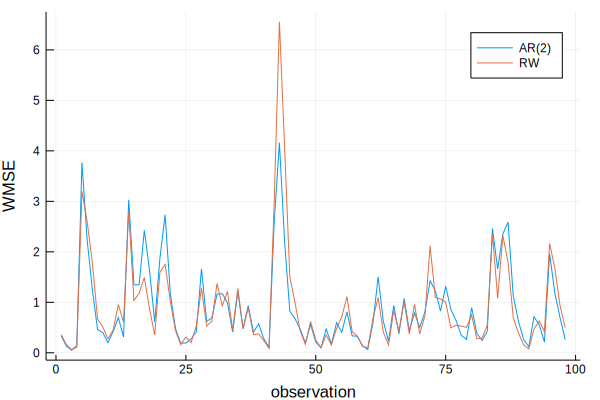

In [24]:
# Plotting
plot(WMSEs, label="AR($ARorder)")
plot!(WMSEsRW, xlabel="observation", ylabel="WMSE", label="RW")

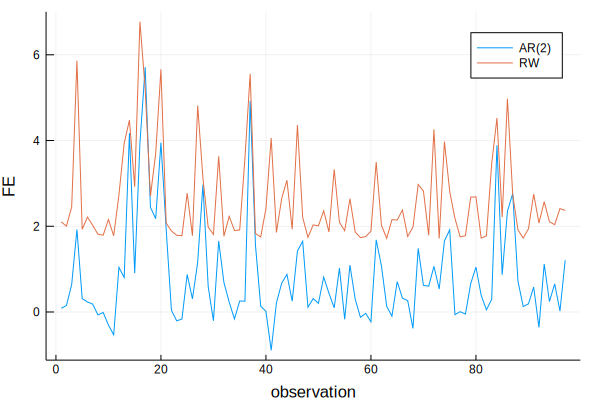

In [25]:
# Free energy
plot(FAR[2:end], label="AR($ARorder)", xlabel="observation", ylabel="FE")
plot!(FRW[2:end], label="RW", xlabel="observation", ylabel="FE")

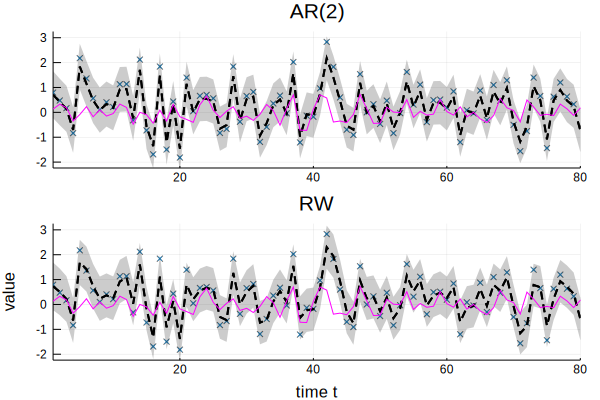

In [26]:
from = 1
upto = 80 # limit for building a graph 
scale = 1.0 # scale for the variance

scatter(y, label="noisy observations", 
        markershape = :xcross, markeralpha = 0.6,
        markersize = 2)
plot!([m_rw, m_rw], fillrange=[m_rw - scale .* sqrt.(v_rw), m_rw + scale .* sqrt.(v_rw)],
      linestyle=:dash,linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :black,
      label=["inferred", "inferred"])
plot!(x, color = :magenta, linewidth = 1.0, label="real state")
pRW = plot!(xlabel="time t", ylabel="value", title="RW")


scatter(y, label="noisy observations", 
        markershape = :xcross, markeralpha = 0.6,
        markersize = 2)
plot!([m_ar, m_ar], fillrange=[m_ar - scale .* sqrt.(v_ar), m_ar + scale .* sqrt.(v_ar)],
      linestyle=:dash, linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :black,
      label=["inferred", "inferred"])
plot!(x, color = :magenta, linewidth = 1.0, label="real state")
pAR = plot!(title="AR($ARorder)", legend=false)

plot(pAR, pRW, xlims=(from, upto), 
    ylims=(minimum(y[from:upto]) - 0.42, maximum(y[from:upto]) + 0.42), 
    layout=(2,1), legend=false)

In [27]:
sum(WMSEs)

87.6679061895392

In [28]:
sum(WMSEsRW)

89.07374597888403

In [29]:
sum(FAR)

84.99446824718225

In [30]:
sum(FRW)

261.1660466980973